## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
from keras.layers import BatchNormalization, Dropout, Dense, Activation
from keras.regularizers import l1, l2, l1_l2
import os
import keras
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape=x_train.shape[1:], 
              output_units=10, 
              num_neurons=[512, 256, 128], 
              drp=0.05, 
              reg='l1', 
              rr=0.01):
    
    if reg == 'l1':
        kr = l1(rr)
    elif reg == 'l2':
        kr = l2(rr)
    else:
        kr = l1_l2(rr)
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=kr, 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=kr, 
                                   name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(drp)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 500
MOMENTUM = 0.9
NEURONS = [500, 500, 500, 500, 500]
DROPOUT = [0.25, 0.2]
REG = ['l1_l2']
REG_RATIO = [1e-10, 1e-120]

In [7]:
results = {}

for drp in DROPOUT:
    for reg, rr in itertools.product(REG, REG_RATIO):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print('dropout:', drp, reg, 'reg_ratio:', rr)
        model = build_mlp(num_neurons=NEURONS,drp=drp,reg=reg,rr=rr)
        #model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "%s-%s-%s" % (str(drp),str(reg),str(rr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

dropout: 0.25 l1_l2 reg_ratio: 1e-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 41s 824us/step - loss: 30.6115 - accuracy: 0.1486 - val_loss: 29.7408 - val_accuracy: 0.2199
Epoch 2/100
50000/50000 [==============================] - 38s 768us/step - loss: 29.2226 - accuracy: 0.2277 - val_loss: 28.5264 - val_accuracy: 0.2486
Epoch 3/100
50000/50000 [==============================] - 36s 724us/step - loss: 28.0432 - accuracy: 0.2646 - val_loss: 27.3949 - val_accuracy: 0.2803
Epoch 4/100
50000/50000 [==============================] - 40s 792us/step - loss: 26.9458 - accuracy: 0.2880 - val_loss: 26.2783 - val_accuracy: 0.3320
Epoch 5/100
50000/50000 [==============================] - 42s 833us/step - loss: 25.9080 - accuracy: 0.3046 - val_loss: 25.2436 - val_accuracy: 0.3600
Epoch 6/100
50000/50000 [==============================] - 36s 729us/step - loss: 24.9158 - accuracy: 0.3220 - val_loss: 24.3084 - val_accuracy: 0.3663
E

50000/50000 [==============================] - 34s 672us/step - loss: 4.5501 - accuracy: 0.5891 - val_loss: 4.6967 - val_accuracy: 0.5135
Epoch 55/100
50000/50000 [==============================] - 34s 675us/step - loss: 4.4071 - accuracy: 0.5936 - val_loss: 4.6746 - val_accuracy: 0.5049
Epoch 56/100
50000/50000 [==============================] - 34s 683us/step - loss: 4.2724 - accuracy: 0.5962 - val_loss: 4.4521 - val_accuracy: 0.5152
Epoch 57/100
50000/50000 [==============================] - 34s 678us/step - loss: 4.1418 - accuracy: 0.6023 - val_loss: 4.3212 - val_accuracy: 0.5230
Epoch 58/100
50000/50000 [==============================] - 34s 680us/step - loss: 4.0167 - accuracy: 0.6076 - val_loss: 4.2756 - val_accuracy: 0.5126
Epoch 59/100
50000/50000 [==============================] - 33s 668us/step - loss: 3.9037 - accuracy: 0.6067 - val_loss: 4.1368 - val_accuracy: 0.5193
Epoch 60/100
50000/50000 [==============================] - 34s 675us/step - loss: 3.7824 - accuracy: 0.613

Epoch 8/100
50000/50000 [==============================] - 32s 641us/step - loss: 23.0882 - accuracy: 0.3464 - val_loss: 22.5041 - val_accuracy: 0.3948
Epoch 9/100
50000/50000 [==============================] - 32s 643us/step - loss: 22.2256 - accuracy: 0.3587 - val_loss: 21.7053 - val_accuracy: 0.3929
Epoch 10/100
50000/50000 [==============================] - 32s 647us/step - loss: 21.3957 - accuracy: 0.3690 - val_loss: 20.8584 - val_accuracy: 0.4089
Epoch 11/100
50000/50000 [==============================] - 32s 642us/step - loss: 20.5913 - accuracy: 0.3780 - val_loss: 20.1248 - val_accuracy: 0.4081
Epoch 12/100
50000/50000 [==============================] - 32s 642us/step - loss: 19.8294 - accuracy: 0.3853 - val_loss: 19.3651 - val_accuracy: 0.4237
Epoch 13/100
50000/50000 [==============================] - 33s 662us/step - loss: 19.0971 - accuracy: 0.3936 - val_loss: 18.6258 - val_accuracy: 0.4395
Epoch 14/100
50000/50000 [==============================] - 32s 645us/step - loss: 1

Epoch 62/100
50000/50000 [==============================] - 33s 651us/step - loss: 3.5687 - accuracy: 0.6193 - val_loss: 3.8430 - val_accuracy: 0.5188
Epoch 63/100
50000/50000 [==============================] - 32s 640us/step - loss: 3.4643 - accuracy: 0.6218 - val_loss: 3.7695 - val_accuracy: 0.5184
Epoch 64/100
50000/50000 [==============================] - 32s 642us/step - loss: 3.3683 - accuracy: 0.6269 - val_loss: 3.6882 - val_accuracy: 0.5139
Epoch 65/100
50000/50000 [==============================] - 32s 649us/step - loss: 3.2675 - accuracy: 0.6316 - val_loss: 3.6065 - val_accuracy: 0.5073
Epoch 66/100
50000/50000 [==============================] - 32s 641us/step - loss: 3.1788 - accuracy: 0.6331 - val_loss: 3.5662 - val_accuracy: 0.4918
Epoch 67/100
50000/50000 [==============================] - 32s 641us/step - loss: 3.0877 - accuracy: 0.6369 - val_loss: 3.8122 - val_accuracy: 0.4297
Epoch 68/100
50000/50000 [==============================] - 33s 650us/step - loss: 3.0056 - ac

50000/50000 [==============================] - 34s 673us/step - loss: 17.6395 - accuracy: 0.4369 - val_loss: 17.2532 - val_accuracy: 0.4570
Epoch 16/100
50000/50000 [==============================] - 34s 676us/step - loss: 16.9862 - accuracy: 0.4438 - val_loss: 16.6398 - val_accuracy: 0.4604
Epoch 17/100
50000/50000 [==============================] - 34s 676us/step - loss: 16.3620 - accuracy: 0.4520 - val_loss: 16.0232 - val_accuracy: 0.4689
Epoch 18/100
50000/50000 [==============================] - 34s 671us/step - loss: 15.7678 - accuracy: 0.4560 - val_loss: 15.4558 - val_accuracy: 0.4706
Epoch 19/100
50000/50000 [==============================] - 34s 673us/step - loss: 15.1970 - accuracy: 0.4604 - val_loss: 14.8896 - val_accuracy: 0.4750
Epoch 20/100
50000/50000 [==============================] - 34s 677us/step - loss: 14.6359 - accuracy: 0.4680 - val_loss: 14.3388 - val_accuracy: 0.4835
Epoch 21/100
50000/50000 [==============================] - 33s 670us/step - loss: 14.1055 - ac

50000/50000 [==============================] - 33s 669us/step - loss: 2.8360 - accuracy: 0.6770 - val_loss: 3.3823 - val_accuracy: 0.5030
Epoch 70/100
50000/50000 [==============================] - 34s 674us/step - loss: 2.7604 - accuracy: 0.6814 - val_loss: 3.5131 - val_accuracy: 0.4594
Epoch 71/100
50000/50000 [==============================] - 33s 668us/step - loss: 2.6762 - accuracy: 0.6864 - val_loss: 3.5694 - val_accuracy: 0.4567
Epoch 72/100
50000/50000 [==============================] - 34s 670us/step - loss: 2.6101 - accuracy: 0.6902 - val_loss: 3.2642 - val_accuracy: 0.4932
Epoch 73/100
50000/50000 [==============================] - 34s 675us/step - loss: 2.5364 - accuracy: 0.6918 - val_loss: 3.1588 - val_accuracy: 0.4949
Epoch 74/100
50000/50000 [==============================] - 34s 670us/step - loss: 2.4698 - accuracy: 0.6957 - val_loss: 3.0762 - val_accuracy: 0.4964
Epoch 75/100
50000/50000 [==============================] - 34s 671us/step - loss: 2.3988 - accuracy: 0.699

50000/50000 [==============================] - 32s 649us/step - loss: 13.6012 - accuracy: 0.4761 - val_loss: 13.3110 - val_accuracy: 0.4943
Epoch 23/100
50000/50000 [==============================] - 32s 647us/step - loss: 13.1119 - accuracy: 0.4835 - val_loss: 12.8903 - val_accuracy: 0.4819
Epoch 24/100
50000/50000 [==============================] - 33s 654us/step - loss: 12.6377 - accuracy: 0.4895 - val_loss: 12.4168 - val_accuracy: 0.4910
Epoch 25/100
50000/50000 [==============================] - 32s 647us/step - loss: 12.1886 - accuracy: 0.4939 - val_loss: 11.9932 - val_accuracy: 0.4892
Epoch 26/100
50000/50000 [==============================] - 32s 648us/step - loss: 11.7480 - accuracy: 0.5012 - val_loss: 11.5596 - val_accuracy: 0.4960
Epoch 27/100
50000/50000 [==============================] - 33s 651us/step - loss: 11.3313 - accuracy: 0.5037 - val_loss: 11.1718 - val_accuracy: 0.4935
Epoch 28/100
50000/50000 [==============================] - 32s 647us/step - loss: 10.9280 - ac

50000/50000 [==============================] - 32s 650us/step - loss: 2.3416 - accuracy: 0.7069 - val_loss: 3.1994 - val_accuracy: 0.4793
Epoch 77/100
50000/50000 [==============================] - 32s 645us/step - loss: 2.2782 - accuracy: 0.7072 - val_loss: 3.0477 - val_accuracy: 0.4916
Epoch 78/100
50000/50000 [==============================] - 33s 659us/step - loss: 2.2229 - accuracy: 0.7112 - val_loss: 3.1759 - val_accuracy: 0.4528
Epoch 79/100
50000/50000 [==============================] - 32s 650us/step - loss: 2.1646 - accuracy: 0.7146 - val_loss: 3.0745 - val_accuracy: 0.4647
Epoch 80/100
50000/50000 [==============================] - 32s 645us/step - loss: 2.1140 - accuracy: 0.7172 - val_loss: 2.8663 - val_accuracy: 0.4984
Epoch 81/100
50000/50000 [==============================] - 32s 646us/step - loss: 2.0657 - accuracy: 0.7185 - val_loss: 2.8379 - val_accuracy: 0.4980
Epoch 82/100
50000/50000 [==============================] - 32s 646us/step - loss: 2.0142 - accuracy: 0.722

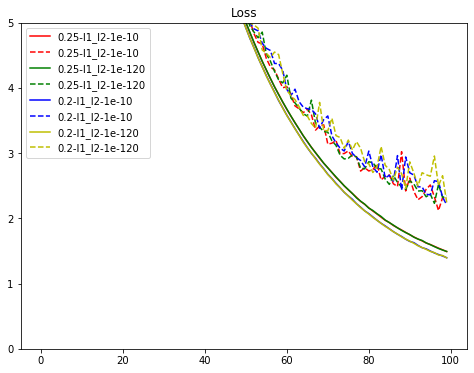

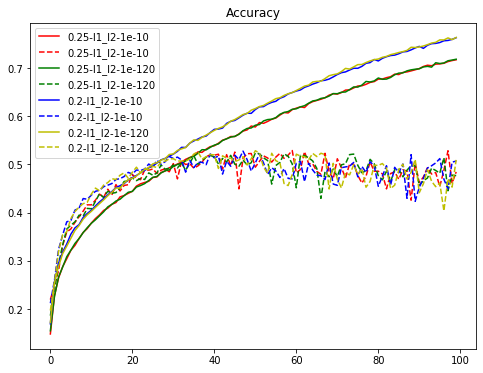

In [8]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()